In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

# Instant Neural Graphics Primitives

In [2]:
class InstantNGP(nn.Module):
	def __init__(self, L = 16, T = 2**19, F = 2, NMin = 16, NMax = 2048, aabbSize = 1.0, hidden = 64, dL = 4, device = 'cuda'):
		super(InstantNGP, self).__init__()
		
		# Attributes
		self.L = L	# number of levels
		self.T = T	# hashtable size
		self.F = F	# dimensions of the feature vectors (size of the hashtable output)
		self.b = np.exp((np.log(NMax) - np.log(NMin))/(L - 1))		# resolution GP ratio
		self.Ns = [int(NMin*np.power(self.b, l)) for l in range(L)]	# resolutions
		self.aabbSize = aabbSize	# size of the Axis-Aligned Bouding Box of the scene (from side to side)
		self.device = device		# torch device (preferably cuda)
		self.dL = dL				# degree of spherical harmonics basis (implemented as positional encoding)
		self.pi1, self.pi2, self.pi3 = 1, 2_654_435_761, 805_459_861	# large prime numbers
		
		
		
		# Multiresolution Hash Table
		self.hashTables = torch.nn.ParameterDict({
			str(i): torch.nn.Parameter((2*torch.rand((T, F), device = device) - 1)*1e-4) for i in range(L)
		})
		
		
		
		# MLPs
		self.densityMlp = nn.Sequential(
			nn.Linear(F*L, hidden), nn.ReLU(),
			nn.Linear(hidden, hidden//4)
		).to(device)
		
		self.colorMlp = nn.Sequential(nn.Linear(hidden//4 + 6*dL + 3, hidden), nn.ReLU(),
			nn.Linear(hidden, hidden), nn.ReLU(),
			nn.Linear(hidden, 3), nn.Sigmoid()
		).to(device)
	
	
	
	def forward(self, o, d):
		S = o.shape[0]
		
		# Extracting only the points inside AABB and mapping coordinates to [0, 1]
		# x: M x 3
		# mask: M
		x = o/self.aabbSize
		mask = (x[:, 0].abs() <= 0.5) & (x[:, 1].abs() <= 0.5) & (x[:, 2].abs() <= 0.5)
		x += 0.5
		x = x[mask]
		M = x.shape[0]
		
		# Multiresolution Hash Enconding
		# cHat: S x 3
		# logSigma: S
		# y: M x L*F
		# corners: M x 8 x 3
		cHat = torch.zeros((S, 3), device = self.device)
		logSigma = torch.zeros(S, device = self.device) - 1e6
		y = torch.empty((M, self.L*self.F), device = self.device)
		corners = torch.zeros((M, 8, 3), dtype = torch.int64, device = self.device)
		
		for i, N in enumerate(self.Ns):
			# Getting corners
			f = torch.floor(N*x)
			c = torch.ceil(N*x)
			
			corners[:, 0b000] = f
			corners[:, 0b001] = torch.stack((c[:, 0], f[:, 1], f[:, 2]), dim = 1)
			corners[:, 0b010] = torch.stack((f[:, 0], c[:, 1], f[:, 2]), dim = 1)
			corners[:, 0b011] = torch.stack((c[:, 0], c[:, 1], f[:, 2]), dim = 1)
			corners[:, 0b100] = torch.stack((f[:, 0], f[:, 1], c[:, 2]), dim = 1)
			corners[:, 0b101] = torch.stack((c[:, 0], f[:, 1], c[:, 2]), dim = 1)
			corners[:, 0b110] = torch.stack((f[:, 0], c[:, 1], c[:, 2]), dim = 1)
			corners[:, 0b111] = c
			
			# Hashing: h(x) = XOR(x_i*pi_i, 1 <= i <= d) % T
			# h: M x 8
			x1 = self.pi1*corners[:, :, 0]
			x2 = self.pi2*corners[:, :, 1]
			x3 = self.pi3*corners[:, :, 2]
			h = torch.remainder(torch.bitwise_xor(torch.bitwise_xor(x1, x2), x3), self.T)
			
			# Interpolation
			# polytope: M x 8 x F
			# w: M x 3
			# m: M x 3
			p = self.hashTables[str(0)][h]
			w = N*x - f
			y[:, self.F*i:self.F*(i + 1)] = InstantNGP.interpolateGrid(w, p)
		
		# MLP pass
		# gammaD: M x (6*dL + 3)
		# out: M x (hidden//4)
		gammaD = InstantNGP.computeGamma(d[mask], self.dL)
		out = self.densityMlp(y)
		logSigma[mask] = out[:, 0]
		cHat[mask] = self.colorMlp(torch.cat((out, gammaD), dim = 1))
		return cHat, torch.exp(logSigma)
	
	
	
	@staticmethod
	def computeGamma(x, l):
		encodedPosition = [x]
		powerOf2Pi = 3.14
		for i in range(l):
			encodedX = powerOf2Pi*x
			encodedPosition.append(torch.sin(encodedX))
			encodedPosition.append(torch.cos(encodedX))
			powerOf2Pi *= 2
		return torch.cat(encodedPosition, dim = 1)
	
	
	
	@staticmethod
	def interpolateGrid(w, p):
		m = 1 - w

		w0 = (m[:,0]*m[:,1]*m[:,2]).unsqueeze(1)
		w1 = (w[:,0]*m[:,1]*m[:,2]).unsqueeze(1)
		w2 = (m[:,0]*w[:,1]*m[:,2]).unsqueeze(1)
		w3 = (w[:,0]*w[:,1]*m[:,2]).unsqueeze(1)
		w4 = (m[:,0]*m[:,1]*w[:,2]).unsqueeze(1)
		w5 = (w[:,0]*m[:,1]*w[:,2]).unsqueeze(1)
		w6 = (m[:,0]*w[:,1]*w[:,2]).unsqueeze(1)
		w7 = (w[:,0]*w[:,1]*w[:,2]).unsqueeze(1)
		
		# return: M x F
		return \
			w0*p[:, 0] + \
			w1*p[:, 1] + \
			w2*p[:, 2] + \
			w3*p[:, 3] + \
			w4*p[:, 4] + \
			w5*p[:, 5] + \
			w6*p[:, 6] + \
			w7*p[:, 7]
	
	
	
	@staticmethod
	def computeCHat(model, o, d, tn = 0.0, tf = 1.0, N = 64):
		# Getting data
		S = o.shape[0]
		
		# Generating t_i
		# t: S x N
		shape = (S, N)
		r = torch.rand(shape, device = model.device)
		step = (tf - tn)/N
		t = torch.linspace(tn, tf - step, N, device = model.device).expand(shape) + step*r
		
		# Generating delta_i, where the last is 1
		# delta: S x N
		ones = torch.ones((S, 1), device = model.device)
		delta = torch.cat((
			t[:, 1:] - t[:, :-1],
			1e9*ones
		), 1)
		
		# Computing c_i and sigma_i
		# o: S x 3
		# d: S x 3
		# t: S x N
		#
		# o': S x N x 3
		# d': S x N x 3
		#
		# c: S x N x 3
		# sigma: S x N
		oPrime = o.unsqueeze(1) + t.unsqueeze(2)*d.unsqueeze(1)	# oPrime(ijk) = o(ik) + t(ij)*d(ik)
		dPrime = d.unsqueeze(1).expand(S, N, 3)
		
		c, sigma = model(oPrime.reshape(-1, 3), dPrime.reshape(-1, 3))
		c = c.reshape(S, N, 3)
		sigma = sigma.reshape(S, N)
		
		# Computing alpha_i T_i, w_i and cHat
		# alpha: S x N
		# T: S x N
		# w: S x N
		# cHat: S x 3
		#
		# Ci = (1 - ai)*Ci+1 + ai*ci
		# C1 = (1 - a1)*...*(1 - an)Cn+1 + (1 - a1)*...*(1 - an-1)ancn + ... + a1c1
		# C1 = Tn(1 - an)Cn+1 + SUM(Ti*ai*ci, 1 <= i <= n)
		# C1 = (Tn - wn)Cn+1 + SUM(wi*ai, 1 <= i <= n)
		alpha = 1 - torch.exp(-sigma*delta)
		T = torch.cumprod(1 - alpha, 1)
		T = torch.cat((ones, T[:, :-1]), dim = 1)
		w = T*alpha
		cHat = (T[:, -1] - w[:, -1]).unsqueeze(1) + (w.unsqueeze(2)*c).sum(dim = 1)	# Cn+1 = white
		
		return cHat
	
	
	
	@staticmethod
	def doTraining(model, optimizer, dataLoader, epochs = 1, tn = 0.0, tf = 10.0, N = 192, maxBatches = 10000):
		model.train()
		lossList = []
		
		for e in range(epochs):
			print(f'epoch: {e + 1} of {epochs}')
			
			length = min(maxBatches, len(dataLoader))
			it = iter(dataLoader)
			for _ in tqdm(range(length)):
				o, d, C = next(it)
				o, d, C = o.to(model.device), d.to(model.device), C.to(model.device)
				
				# Computing loss
				cHat = InstantNGP.computeCHat(model, o, d, tn = tn, tf = tf, N = N)
				loss = ((cHat - C)**2).mean()
				
				# Backpropagation
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				lossList.append(loss.item())
			
			# Old
			# Decaying learning rate
			#scheduler.step()
		
		model.eval()
		return lossList
	
	
	
	@staticmethod
	@torch.no_grad()
	def render(model, pos, eye, up, tn = 0.0, tf = 1.0, N = 192, imageWidth = 400, imageHeight = 400, chunkSize = 1024, fov = 75):
		# Generating the view matrix
		normalize = lambda x : torch.nn.functional.normalize(x, dim = 0)
		cross = lambda x, y : torch.cross(x, y, dim = 0)
		dot = lambda x, y : torch.dot(x, y).unsqueeze(0)
		
		z = normalize(eye - pos)
		x = normalize(cross(up, z))
		y = normalize(cross(z, x))
		
		# local*mat = global
		mat = torch.stack([x, y, z])
		
		# Generating rays
		tangent = 3.14/360.0
		tangent *= fov
		tangent = np.tan(tangent)
		ratio = imageWidth/imageHeight
		
		px = tangent*torch.linspace(-ratio, ratio, imageWidth)
		py = tangent*torch.linspace(-1.0, 1.0, imageHeight)
		numPx = imageWidth*imageHeight
		d = torch.zeros((numPx, 3))
				
		for j in range(imageHeight):
			for i in range(imageWidth):
				k = i + j*imageWidth
				d[k, 0] = px[i]
				d[k, 1] = py[j]
				d[k, 2] = -1.0
		
		d = torch.matmul(d, mat)
		d = torch.nn.functional.normalize(d, dim = 1)
		o = eye.repeat(imageWidth*imageHeight, 1)
		
		# Rendering each ray in chunks
		chunks = []
		numChunk = int(np.ceil(numPx/chunkSize))
		with torch.no_grad():
			for c in tqdm(range(numChunk)):
				oChunk = o[c*chunkSize:(c + 1)*chunkSize].to(model.device)
				dChunk = d[c*chunkSize:(c + 1)*chunkSize].to(model.device)
				cHat = InstantNGP.computeCHat(model, oChunk, dChunk, tn = tn, tf = tf, N = N)
				chunks.append(cHat.to('cpu'))

		return torch.cat(chunks).reshape(imageHeight, imageWidth, 3)

## Training model

### Load data

In [18]:
device = 'cuda'
torch.cuda.empty_cache()


data = np.load('data/training_data_800x800.pkl', allow_pickle = True)
trainTensor = torch.from_numpy(data)#.to(device)
trainTensorDataset = TensorDataset(trainTensor[:, :3], trainTensor[:, 3:6], trainTensor[:, 6:])

### Generate batches

In [19]:
trainDataLoader = DataLoader(trainTensorDataset, batch_size = 2**14, shuffle = True)

### Generate the Instant NGP model and the ADAM optimizer

In [20]:
model = InstantNGP(aabbSize = 3.0).to(device)
optimizer = torch.optim.Adam([
	{"params": model.hashTables.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 0.0},
	{"params": model.densityMlp.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 1e-6},
	{"params": model.colorMlp.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 1e-6}
])
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1, 2, 3], gamma = 0.5)

### Train

epoch: 1 of 1


100%|██████████| 3907/3907 [59:02<00:00,  1.10it/s]  


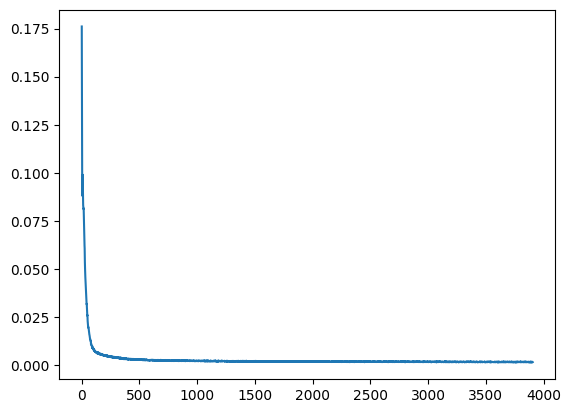

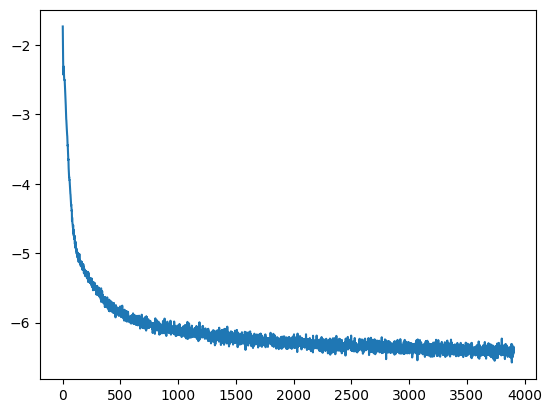

In [21]:
lossList = InstantNGP.doTraining(model, optimizer, trainDataLoader, epochs = 1, tn = 2, tf = 6, N = 192, maxBatches = 100000)

torch.save(model.state_dict(), "weights/instantNgpWeights2.w")
torch.save(optimizer.state_dict(), "optimizers/instantNgpOptimizer2.o")
torch.save(lossList, "loss/instantNgpLoss2.l")

#xs = [x for x in range(len(lossList))]
#plt.plot(xs, lossList)
#plt.show()
#plt.plot(xs, [np.log(l) for l in lossList])
#plt.show()

## Loading model

### Load the Instant NGP model and the ADAM optimizer

In [3]:
device = 'cuda'
torch.cuda.empty_cache()

model = InstantNGP(aabbSize = 3.0).to(device)
optimizer = torch.optim.Adam([
	{"params": model.hashTables.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 0.0},
	{"params": model.densityMlp.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 1e-6},
	{"params": model.colorMlp.parameters(), "lr": 1e-2, "betas": (0.9, 0.99), "eps": 1e-15, "weight_decay": 1e-6}
])

model.load_state_dict(torch.load("weights/instantNgpWeights.w"))
optimizer.load_state_dict(torch.load("optimizers/instantNgpOptimizer.o"))
lossList = torch.load("loss/instantNgpLoss.l")

### Plot the loss in linear and semi-log graph

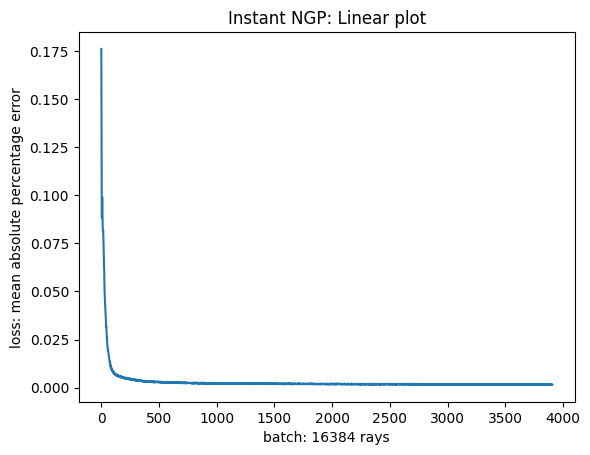

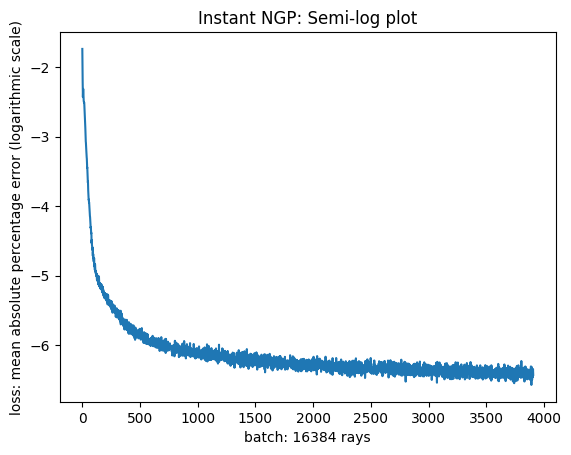

In [4]:
index = 0*int(len(lossList)/2)

xs = [index + x for x in range(len(lossList) - index)]
plt.plot(xs, lossList[index:])
plt.title("Instant NGP: Linear plot")
plt.xlabel("batch: 16384 rays")
plt.ylabel("loss: mean absolute percentage error")
plt.show()

plt.plot(xs, [np.log(l) for l in lossList[index:]])
plt.title("Instant NGP: Semi-log plot")
plt.xlabel("batch: 16384 rays")
plt.ylabel("loss: mean absolute percentage error (logarithmic scale)")
plt.show()

## Rendering

### Render a single image

In [69]:
pos = torch.tensor([0, 0,  0.0])
#eye = torch.tensor([2.1031, -1.0323,  3.2804])
#eye = torch.tensor([0.3, -0.8, 0.3])
eye = torch.tensor([1.5, 1.5, 0.3])
up = torch.tensor([0.0, 0.0, -1.0])


eye[0] = 1.5*np.cos(270*(2*np.pi)/360)
eye[1] = 1.5*np.sin(270*(2*np.pi)/360)
eye[2] = 0.3 - 0.2*np.cos(270*(4*np.pi)/360)
cHat = InstantNGP.render(model, pos, eye, up, tn = 0.0, tf = 4.0, N = 384, imageWidth = 1*192, imageHeight = 1*108, chunkSize = 2**10, fov = 75)
print(cHat.shape)

100%|██████████| 21/21 [00:02<00:00,  9.75it/s]

torch.Size([108, 192, 3])


### Plot the rendered image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


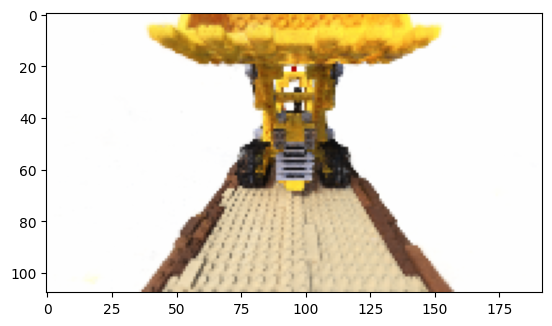

In [70]:
plt.imshow(cHat)
plt.show()

### Save the rendered image

In [37]:
Image.fromarray((cHat.numpy()*255).astype(np.uint8), "RGB").save("instant_ngp3.png")

### Generate and Save an animation

In [71]:
pos = torch.tensor([0.0, 0.0, 0.0])
eye = torch.tensor([-0.5,  -0.7,  0.3])
up = torch.tensor([0.0, 0.0, -1.0])

frames = []
numFrame = 120
duration = int(np.round(2000/numFrame))
for i in tqdm(range(numFrame)):
	angleFraction = 2*np.pi/numFrame
	eye[0] = 1.5*np.cos(i*angleFraction)
	eye[1] = 1.5*np.sin(i*angleFraction)
	eye[2] = 0.3 - 0.2*np.cos(2*i*angleFraction)
	cHat = InstantNGP.render(model, pos, eye, up, tn = 0, tf = 4, N = 384, imageWidth = 10*192, imageHeight = 10*108, chunkSize = 1024)
	frames.append(Image.fromarray((cHat.detach().numpy()*255).astype(np.uint8), "RGB"))
frames[0].save("instant_ngpGood.gif", save_all=True, append_images=frames[1:], duration=duration, loop=0)

100%|██████████| 120/120 [7:59:25<00:00, 239.72s/it]


In [72]:
for i in range(len(frames)):
	frames[i].save(f'animation/img{i}.png')

# Tests

In [11]:
L = 16
T = 2**14
F = 2
NMin = 16
NMax = 2**19

b = np.exp((np.log(NMax) - np.log(NMin))/(L - 1))
N = [int(NMin*np.power(b, l)) for l in range(L)]
print(N)

[16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]


In [43]:
L = 16
T = 2**14
F = 2

N = 8
M = 5



x = (torch.rand((M, 3))*2 - 1)/2 + 0.5
corners = torch.zeros((M, 8, 3), dtype = torch.int64)



f = torch.floor(N*x)
c = torch.ceil(N*x)

corners[:, 0b000] = f
corners[:, 0b001] = torch.stack((c[:, 0], f[:, 1], f[:, 2]), dim = 1)
corners[:, 0b010] = torch.stack((f[:, 0], c[:, 1], f[:, 2]), dim = 1)
corners[:, 0b011] = torch.stack((c[:, 0], c[:, 1], f[:, 2]), dim = 1)
corners[:, 0b100] = torch.stack((f[:, 0], f[:, 1], c[:, 2]), dim = 1)
corners[:, 0b101] = torch.stack((c[:, 0], f[:, 1], c[:, 2]), dim = 1)
corners[:, 0b110] = torch.stack((f[:, 0], c[:, 1], c[:, 2]), dim = 1)
corners[:, 0b111] = c



x1 = 1*corners[:, :, 0]
x2 = 2_654_435_761*corners[:, :, 1]
x3 = 805_459_861*corners[:, :, 2]
h = torch.remainder(torch.bitwise_xor(torch.bitwise_xor(x1, x2), x3), T)



w = N*x - f

In [83]:
polytope.shape

torch.Size([5, 8, 2])

In [37]:
hashTables = torch.nn.ParameterDict({
	str(i): torch.nn.Parameter((2*torch.rand((T, F)) - 1)) for i in range(L)
})

In [73]:
polytope = hashTables[str(0)][h]
m = 1 - w

w0 = (m[:,0]*m[:,1]*m[:,2]).unsqueeze(1)
w1 = (w[:,0]*m[:,1]*m[:,2]).unsqueeze(1)
w2 = (m[:,0]*w[:,1]*m[:,2]).unsqueeze(1)
w3 = (w[:,0]*w[:,1]*m[:,2]).unsqueeze(1)
w4 = (m[:,0]*m[:,1]*w[:,2]).unsqueeze(1)
w5 = (w[:,0]*m[:,1]*w[:,2]).unsqueeze(1)
w6 = (m[:,0]*w[:,1]*w[:,2]).unsqueeze(1)
w7 = (w[:,0]*w[:,1]*w[:,2]).unsqueeze(1)

y = w0*polytope[:, 0] + \
	w1*polytope[:, 1] + \
	w2*polytope[:, 2] + \
	w3*polytope[:, 3] + \
	w4*polytope[:, 4] + \
	w5*polytope[:, 5] + \
	w6*polytope[:, 6] + \
	w7*polytope[:, 7]

In [76]:
polytope.shape

torch.Size([5, 8, 2])

In [77]:
(hashTables[str(0)][h].transpose(-1, -2)).shape

torch.Size([5, 2, 8])

In [78]:
yHash = hashTables[str(0)][h].transpose(-1, -2)
volume = yHash.reshape(M, F, 2, 2, 2)
yPrime = torch.nn.functional.grid_sample(
	volume,
	((x*N - f) - 0.5).unsqueeze(1).unsqueeze(1).unsqueeze(1)
).squeeze(-1).squeeze(-1).squeeze(-1)

c:\Users\srNando\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [79]:
yPrime

tensor([[-0.0721, -0.4603],
        [-0.0921,  0.2348],
        [-0.1352, -0.2066],
        [ 0.0410, -0.3581],
        [ 0.0118, -0.2313]], grad_fn=<SqueezeBackward1>)

In [75]:
y

tensor([[-0.0721, -0.4603],
        [-0.0921,  0.2348],
        [-0.1352, -0.2066],
        [ 0.0410, -0.3581],
        [ 0.0118, -0.2313]], grad_fn=<AddBackward0>)

In [72]:
test.unsqueeze(1)*polytope[:, 1]

tensor([[  2.5388,   6.7913],
        [ 78.7976, -20.0341],
        [  0.8490,   0.2729],
        [ -9.8928,   6.3857],
        [ 72.7049,  40.3088]], grad_fn=<MulBackward0>)

In [20]:
test = torch.tensor([10.0, 100.0, -1.0, -10.0, -100.0])
test2 = torch.rand((5, 3))
print(test)
print(test2)
print(test.unsqueeze(1) + test2)

tensor([  10.,  100.,   -1.,  -10., -100.])
tensor([[0.4182, 0.9031, 0.6505],
        [0.6063, 0.1602, 0.9129],
        [0.8426, 0.6710, 0.0529],
        [0.4537, 0.5522, 0.1865],
        [0.9481, 0.9616, 0.4978]])
tensor([[ 10.4182,  10.9031,  10.6505],
        [100.6063, 100.1602, 100.9129],
        [ -0.1574,  -0.3290,  -0.9471],
        [ -9.5463,  -9.4478,  -9.8135],
        [-99.0519, -99.0384, -99.5022]])


In [66]:
w0.unsqueeze(1)

tensor([[0.5899],
        [0.2615],
        [0.3232],
        [0.0085],
        [0.0384]])

In [47]:
w

tensor([[0.0682, 0.3554, 0.0179],
        [0.2453, 0.1650, 0.5849],
        [0.4178, 0.0391, 0.4222],
        [0.6412, 0.6957, 0.9226],
        [0.4665, 0.8106, 0.6203]])

In [49]:
print(N*x)
print(f)
print(c)
print(w)

tensor([[4.0682, 5.3554, 5.0179],
        [5.2453, 7.1650, 2.5849],
        [7.4178, 0.0391, 1.4222],
        [3.6412, 0.6957, 7.9226],
        [2.4665, 6.8106, 5.6203]])
tensor([[4., 5., 5.],
        [5., 7., 2.],
        [7., 0., 1.],
        [3., 0., 7.],
        [2., 6., 5.]])
tensor([[5., 6., 6.],
        [6., 8., 3.],
        [8., 1., 2.],
        [4., 1., 8.],
        [3., 7., 6.]])
tensor([[0.0682, 0.3554, 0.0179],
        [0.2453, 0.1650, 0.5849],
        [0.4178, 0.0391, 0.4222],
        [0.6412, 0.6957, 0.9226],
        [0.4665, 0.8106, 0.6203]])


In [ ]:
x1 = 1*corners[:, :, 0]
x2 = 2_654_435_761*corners[:, :, 1]
x3 = 805_459_861*corners[:, :, 2]
h = torch.remainder(torch.bitwise_xor(torch.bitwise_xor(x1, x2), x3), self.T)